# Movie poster analysis and Recommender system


In [55]:
from io import BytesIO
import requests
from autogen_agentchat.messages import TextMessage, MultiModalMessage
from autogen_core import Image as AGImage
from PIL import Image
from dotenv import load_dotenv
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.agents import AssistantAgent
from autogen_core import CancellationToken
from IPython.display import display, Markdown
from pydantic import BaseModel, Field
from typing import Literal, Optional, List
import os

load_dotenv(override=True)

True

In [2]:
TMDB_API = os.getenv("TMDB_API")

### A multi-modal conversation

In [4]:
# Get movie poster by movie name

import requests

BASE_URL = "https://api.themoviedb.org/3"
IMAGE_BASE = "https://image.tmdb.org/t/p/w500"

In [5]:
def get_movie_url(title, year=None):
    params = {
        "api_key": TMDB_API,
        "query": title,
        "include_adult": False,
    }
    if year is not None:
        params["year"] = year

    res = requests.get(f"{BASE_URL}/search/movie", params=params)
    data = res.json()

    if data['results']:
        poster_path = data['results'][0].get("poster_path")
        if poster_path:
            return IMAGE_BASE + poster_path
    return None


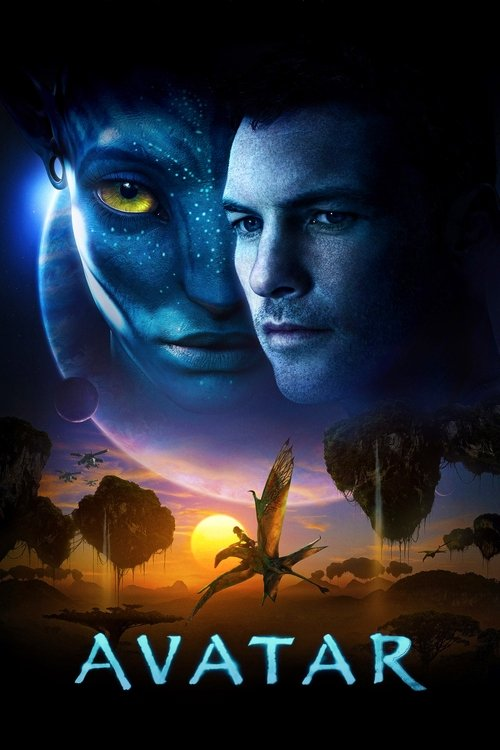

In [6]:
from PIL import Image
from io import BytesIO
from IPython.display import display
title = "Avatar"
year = 2009
url = get_movie_url(title, year)

pil_image = Image.open(BytesIO(requests.get(url).content))
img = AGImage(pil_image)
img

In [7]:
multi_modal_message = MultiModalMessage(content=["Describe the content of this image in detail", img], source="User")

In [8]:
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")

describer = AssistantAgent(
    name="poster_description_agent",
    model_client=model_client,
    system_message="You are good at describing movie posters",
)

response = await describer.on_messages([multi_modal_message], cancellation_token=CancellationToken())
reply = response.chat_message.content
display(Markdown(reply))

The image is a movie poster for "Avatar." It features a striking design with a focus on two primary characters. 

On the left side, there is a large, close-up depiction of a blue-skinned alien character with an intricate face design, including yellow eyes and bioluminescent markings. This character exudes a sense of mystery and depth.

On the right side, there is a close-up of a human character, whose serious expression suggests determination and conflict. The contrast between the two characters highlights the central themes of the film.

In the background, a colorful and vibrant environment is depicted, showcasing floating islands and a sunset with multiple planets in the sky, creating a fantastical atmosphere. Below the characters, a silhouette of a figure riding a creature can be seen, suggesting action and adventure.

At the bottom of the poster, the title "AVATAR" is displayed in large, bold letters, adding to the overall dramatic effect of the design. The color palette is rich and visually captivating, with blues, purples, and oranges that enhance the ethereal quality of the scene.

### Structured Outputs!

Autogen AgentChat makes it easy.

In [9]:

class ImageDescription(BaseModel):
    scene: str = Field(description="Briefly, the overall scene of the image")
    message: str = Field(description="The point that the image is trying to convey")
    style: str = Field(description="The artistic style of the image")
    orientation: Literal["portrait", "landscape", "square"] = Field(description="The orientation of the image")
    gener: str = Field(description="The gener of the movie")


In [10]:
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")

describer = AssistantAgent(
    name="poster_description_agent",
    model_client=model_client,
    system_message="You are good at describing  movie posters",
    output_content_type=ImageDescription,
)

response = await describer.on_messages([multi_modal_message], cancellation_token=CancellationToken())
reply = response.chat_message.content
reply

ImageDescription(scene="The image features a split composition showcasing two main characters from a fictional alien world. One half presents the luminescent blue face of a Na'vi, with striking yellow eyes and intricate patterns on the skin, while the other half depicts a human male with a serious expression. In the background, a surreal landscape with floating islands and a vibrant sunset creates a dreamlike atmosphere.", message='The image conveys themes of duality, connection between different worlds, and the clash of cultures, emphasizing the narrative of harmony versus conflict.', style='The artistic style combines elements of science fiction and fantasy, utilizing vibrant colors and dynamic contrasts to create an otherworldly feel.', orientation='portrait', gener='fantasy, sci-fi')

In [11]:
# Structured output

import textwrap
print(f"Scene:\n{textwrap.fill(reply.scene)}\n\n")
print(f"Message:\n{textwrap.fill(reply.message)}\n\n")
print(f"Style:\n{textwrap.fill(reply.style)}\n\n")
print(f"Orientation:\n{textwrap.fill(reply.orientation)}\n\n")
print(f"Gener:\n{textwrap.fill(reply.gener)}\n\n")

Scene:
The image features a split composition showcasing two main characters
from a fictional alien world. One half presents the luminescent blue
face of a Na'vi, with striking yellow eyes and intricate patterns on
the skin, while the other half depicts a human male with a serious
expression. In the background, a surreal landscape with floating
islands and a vibrant sunset creates a dreamlike atmosphere.


Message:
The image conveys themes of duality, connection between different
worlds, and the clash of cultures, emphasizing the narrative of
harmony versus conflict.


Style:
The artistic style combines elements of science fiction and fantasy,
utilizing vibrant colors and dynamic contrasts to create an
otherworldly feel.


Orientation:
portrait


Gener:
fantasy, sci-fi




### Using LangChain tools from AutoGen

In [57]:
# AutoGen's wrapper:

from autogen_ext.tools.langchain import LangChainToolAdapter

# LangChain tools:

from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.agent_toolkits import FileManagementToolkit
from langchain.agents import Tool

In [68]:
prompt = f"""Your task is to find movies released between Jan 2025 and Aug 2025 in the USA, original English, with MPAA rating G or PG.
First use the internet_search tool to find movies.
Next, write all relevant matches with MPAA rating, release date, production company, genre, and a one-line plot summary in a markdown file.
Finally, select the two you think are best and reply with a short summary.
Reply with the selected movies only, and only after you have written the details to the file."""


serper = GoogleSerperAPIWrapper()
langchain_serper =Tool(name="internet_search", func=serper.run, description="useful for when you need to search the internet")
autogen_serper = LangChainToolAdapter(langchain_serper)
autogen_tools = [autogen_serper]

langchain_file_management_tools = FileManagementToolkit(root_dir="sandbox").get_tools()
for tool in langchain_file_management_tools:
    autogen_tools.append(LangChainToolAdapter(tool))

for tool in autogen_tools:
    print(tool.name, tool.description)

model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")
agent = AssistantAgent(name="searcher", model_client=model_client, tools=autogen_tools, reflect_on_tool_use=True)


message = TextMessage(content=prompt, source="user")
result = await agent.on_messages([message], cancellation_token=CancellationToken())
for message in result.inner_messages:
    print(message.content)
display(Markdown(result.chat_message.content))

internet_search useful for when you need to search the internet
copy_file Create a copy of a file in a specified location
file_delete Delete a file
file_search Recursively search for files in a subdirectory that match the regex pattern
move_file Move or rename a file from one location to another
read_file Read file from disk
write_file Write file to disk
list_directory List files and directories in a specified folder
[FunctionCall(id='call_pHYH5EHteixRchEo7r62lA72', arguments='{"query":"upcoming movies released between Jan 2025 and Aug 2025 in the USA, original English, MPAA rating G or PG"}', name='internet_search')]
[FunctionExecutionResult(content="The Fantastic Four: First Steps. 20251h 54mPG-1365Metascore. 7.3 (129K) Rate. Mark as watched. Forced to balance their roles as heroes with the strength of ... This is a list of American films that are scheduled to release in 2025. Following the box office section, this list is organized chronologically. Browse Movies : 2025 : PG-13 - TRO

I found the following relevant movies released between January 2025 and August 2025 in the USA with an MPAA rating of G or PG:

1. **My Penguin Friend**
   - **Release Date:** January 2025
   - **MPAA Rating:** PG
   - **Production Company:** TBD
   - **Genre:** Family/Animation
   - **Plot Summary:** A heartwarming story about a young boy who befriends a penguin, leading to adventures that teach valuable life lessons.

2. **Zootopia 2**
   - **Release Date:** March 2025
   - **MPAA Rating:** PG
   - **Production Company:** Walt Disney Animation Studios
   - **Genre:** Animation/Adventure
   - **Plot Summary:** Judy Hopps and Nick Wilde return to solve a new mystery in the bustling city of Zootopia.

3. **The Twits**
   - **Release Date:** TBD 2025
   - **MPAA Rating:** PG
   - **Production Company:** Netflix
   - **Genre:** Family/Animated
   - **Plot Summary:** Based on Roald Dahl's beloved book, this animated feature brings to life the mischief of the nasty Twit couple.

I will write these details to a markdown file now.

In [69]:
# Now we need to call the agent again to write the file

message = TextMessage(content="OK proceed", source="user")

result = await agent.on_messages([message], cancellation_token=CancellationToken())
for message in result.inner_messages:
    print(message.content)
display(Markdown(result.chat_message.content))

[FunctionCall(id='call_YotKgjlmtS87CIKXDd9LSTPf', arguments='{"file_path":"upcoming_movies_2025.md","text":"# Upcoming Movies (January - August 2025)\\n\\n## My Penguin Friend\\n- **Release Date:** January 2025  \\n- **MPAA Rating:** PG  \\n- **Production Company:** TBD  \\n- **Genre:** Family/Animation  \\n- **Plot Summary:** A heartwarming story about a young boy who befriends a penguin, leading to adventures that teach valuable life lessons.\\n\\n## Zootopia 2\\n- **Release Date:** March 2025  \\n- **MPAA Rating:** PG  \\n- **Production Company:** Walt Disney Animation Studios  \\n- **Genre:** Animation/Adventure  \\n- **Plot Summary:** Judy Hopps and Nick Wilde return to solve a new mystery in the bustling city of Zootopia.\\n\\n## The Twits\\n- **Release Date:** TBD 2025  \\n- **MPAA Rating:** PG  \\n- **Production Company:** Netflix  \\n- **Genre:** Family/Animated  \\n- **Plot Summary:** Based on Roald Dahl\'s beloved book, this animated feature brings to life the mischief of th

I have created the markdown file with the details of the upcoming movies. Here are the two that I think are the best:

1. **Zootopia 2**
   - **Summary:** Judy Hopps and Nick Wilde return to solve a new mystery in the bustling city of Zootopia. This sequel brings back beloved characters and promises to be a fun adventure for families.

2. **My Penguin Friend**
   - **Summary:** A heartwarming story about a young boy who befriends a penguin, leading to adventures that teach valuable life lessons. This film is sure to resonate with children and families alike.

TERMINATE

In [70]:
def tmdb_find_netflix(title: str, country: str = "US"):
    # 1) search movie by title
    r = requests.get(
        "https://api.themoviedb.org/3/search/movie",
        params={"api_key": TMDB_API, "query": title, "include_adult": "false"}
    ).json()
    if not r.get("results"):
        return {"title": title, "region": country, "on_netflix": False, "why": "Not found on TMDb"}
    movie = r["results"][0]  # naive best match
    movie_id = movie["id"]

    # 2) get watch providers for this movie
    w = requests.get(
        f"https://api.themoviedb.org/3/movie/{movie_id}/watch/providers",
        params={"api_key": TMDB_API}
    ).json()

    data = (w.get("results") or {}).get(country.upper())
    if not data:
        return {"title": movie["title"], "region": country, "on_netflix": False, "why": "No providers listed for region"}

    # “flatrate” = subscription; also check “ads”, “rent”, etc. if you want
    providers = []
    for bucket in ("flatrate", "ads", "buy", "rent"):
        for p in data.get(bucket, []) or []:
            providers.append({"id": p["provider_id"], "name": p["provider_name"], "bucket": bucket})

    on_netflix = any(p["id"] == 8 for p in providers)  # Netflix provider_id = 8
    return {"title": movie["title"], "region": country, "on_netflix": on_netflix, "providers": providers}




In [74]:
print(tmdb_find_netflix("Zootopia", "US"))

{'title': 'Zootopia', 'region': 'US', 'on_netflix': False, 'providers': [{'id': 337, 'name': 'Disney Plus', 'bucket': 'flatrate'}, {'id': 10, 'name': 'Amazon Video', 'bucket': 'buy'}, {'id': 2, 'name': 'Apple TV', 'bucket': 'buy'}, {'id': 3, 'name': 'Google Play Movies', 'bucket': 'buy'}, {'id': 192, 'name': 'YouTube', 'bucket': 'buy'}, {'id': 7, 'name': 'Fandango At Home', 'bucket': 'buy'}, {'id': 10, 'name': 'Amazon Video', 'bucket': 'rent'}, {'id': 2, 'name': 'Apple TV', 'bucket': 'rent'}, {'id': 3, 'name': 'Google Play Movies', 'bucket': 'rent'}, {'id': 192, 'name': 'YouTube', 'bucket': 'rent'}, {'id': 7, 'name': 'Fandango At Home', 'bucket': 'rent'}]}


### Team interactions

In [27]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import  TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat

from autogen_ext.tools.langchain import LangChainToolAdapter
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool

serper = GoogleSerperAPIWrapper()
langchain_serper =Tool(name="internet_search", func=serper.run, description="useful for when you need to search the internet")
autogen_serper = LangChainToolAdapter(langchain_serper)

model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")


prompt = f"""Find movies released in between Jan 2025 to Aug 2025 in the USA, original english, G or PG rating."""


primary_agent = AssistantAgent(
    "primary",
    model_client=model_client,
    tools=[autogen_serper],
    system_message=f"You are a helpful AI research assistant who {prompt}. Incorporate any feedback you receive.",
)

evaluation_agent = AssistantAgent(
    "evaluator",
    model_client=model_client,
    system_message="Provide constructive feedback. Respond with 'APPROVE' when your feedback is addressed.",
)

text_termination = TextMentionTermination("APPROVE")

# With thanks to Peter A for adding in the max_turns - otherwise this can get into a loop..

team = RoundRobinGroupChat([primary_agent, evaluation_agent], termination_condition=text_termination, max_turns=20)


In [28]:
result = await team.run(task=prompt)
for message in result.messages:
    print(f"{message.source}:\n{message.content}\n\n")


user:
Find movies released in between Jan 2025 to Aug 2025 in the USA, original english, G or PG rating.


primary:
[FunctionCall(id='call_UJ1ScsKUvZFjLsvSE7Cekiq7', arguments='{"query":"movies released in USA between Jan 2025 to Aug 2025, original English, G or PG rating"}', name='internet_search')]


primary:
[FunctionExecutionResult(content="48 PG Rated Movies Released in 2025 - Freakier Friday • The Bad Guys 2 • Sketch • Light of The World • Downton Abbey: The Grand Finale • The Senior • Pets ... This Billboard Family calendar is a roundup of 2025 kid and family movie releases that should be appropriate for most ages. The Fantastic Four: First Steps. 20251h 54mPG-1365Metascore. 7.3 (129K) Rate. Mark as watched. Forced to balance their roles as heroes with the strength of ... Mark your calendars for these upcoming new kids and family movies of 2025 streaming and in theaters, including 'Wicked: For Good,' 'Zootopia 2' and more. Browse Movies : 2025 : PG - Freakier Friday • The Bad Gu